In [1]:
! pip install transformers

In [2]:
!pip install torch

In [3]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from tqdm import tqdm
import html
import unicodedata
from sklearn import metrics
import transformers

#nlp
import string
import re    #for regex
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MANALI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [6]:
!pip install datasets

In [6]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
data = dataset['train'].to_pandas()
data.describe()

  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [7]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    return text

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135556 entries, 0 to 135555
Columns: 131 entries, comment_id to annotator_sexuality_other
dtypes: bool(103), float64(19), int32(2), int8(1), object(6)
memory usage: 40.3+ MB


In [9]:
data.shape

(135556, 131)

In [10]:
data.columns

Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_hindu', 'annotator_religion_jewish',
       'annotator_religion_mormon', 'annotator_religion_muslim',
       'annotator_religion_nothing', 'annotator_religion_other',
       'annotator_sexuality_bisexual', 'annotator_sexuality_gay',
       'annotator_sexuality_straight', 'annotator_sexuality_other'],
      dtype='object', length=131)

In [11]:
data.isnull().sum()

comment_id                      0
annotator_id                    0
platform                        0
sentiment                       0
respect                         0
                               ..
annotator_religion_other        0
annotator_sexuality_bisexual    0
annotator_sexuality_gay         0
annotator_sexuality_straight    0
annotator_sexuality_other       0
Length: 131, dtype: int64

In [12]:
data['num_words'] = [len(sent.split()) for sent in data['text']]


In [13]:
# maximum and minimum number of words per sentencs
max(data['num_words']), min(data['num_words'])

(128, 1)

In [14]:
data['sentiment'].value_counts()

4.0    61435
3.0    35243
2.0    19785
0.0     9658
1.0     9435
Name: sentiment, dtype: int64

In [15]:
data['hatespeech'].value_counts()

0.0    80624
2.0    46021
1.0     8911
Name: hatespeech, dtype: int64

In [16]:
data['violence'].value_counts()

0.0    67922
1.0    30727
4.0    13404
2.0    12241
3.0    11262
Name: violence, dtype: int64

In [17]:
data['dehumanize'].value_counts()

0.0    31855
3.0    28653
1.0    28434
2.0    25292
4.0    21322
Name: dehumanize, dtype: int64

In [18]:
data['genocide'].value_counts()

0.0    90058
1.0    22838
4.0     9252
2.0     8107
3.0     5301
Name: genocide, dtype: int64

In [20]:
data['attack_defend'].value_counts()

3.0    44883
2.0    38201
4.0    33468
1.0    11046
0.0     7958
Name: attack_defend, dtype: int64

In [21]:
df=data.iloc[:, 3:13]
df['hatespeech'] = df['hatespeech'].replace(1,3)
df['hatespeech'] = df['hatespeech'].replace(2,4)
#df.loc[ df['hatespeech'] == '1', 'hatespeech'] = '3'
f = lambda x: 1 if x>=3.0 else 0
df=df.applymap(f)

In [22]:
new_df=pd.DataFrame()
new_df['text'] = data['text']
new_df['labels'] = df.iloc[:,:].values.tolist()
new_df['num_words']=data['num_words']


In [23]:
new_df.head()

,text,labels,num_words
0,Yes indeed. She sort of reminds me of the elde...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",51
1,The trans women reading this tweet right now i...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10
2,Question: These 4 broads who criticize America...,"[1, 1, 1, 1, 1, 1, 0, 0, 1, 1]",43
3,It is about time for all illegals to go back t...,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",24
4,For starters bend over the one in pink and kic...,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1]",26


In [24]:
new_df['toxic'] = np.where(data['hatespeech'] >= 1, 'Toxic', 'Non-Toxic')


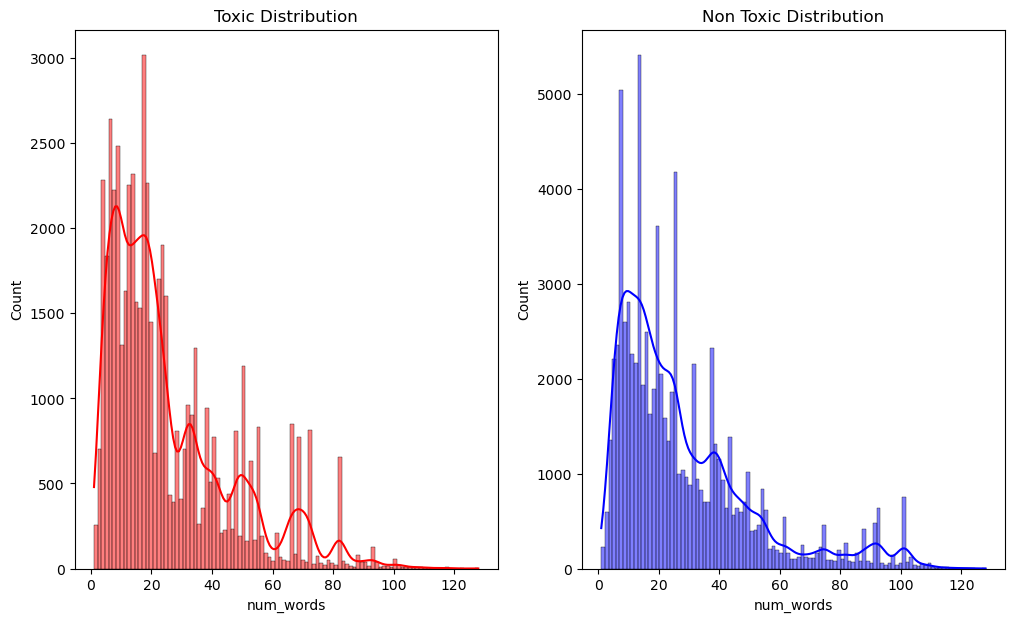

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
sns.histplot(new_df[new_df['toxic'] == 'Toxic']['num_words'], kde= True, ax=ax[0], color= 'r')
sns.histplot(new_df[new_df['toxic'] == 'Non-Toxic']['num_words'], kde= True, ax=ax[1], color= 'b')
ax[0].set_title("Toxic Distribution")
ax[1].set_title("Non Toxic Distribution")
plt.show();

In [26]:
new_df['toxic'].value_counts()

Non-Toxic    80624
Toxic        54932
Name: toxic, dtype: int64

In [27]:
!pip install wordcloud

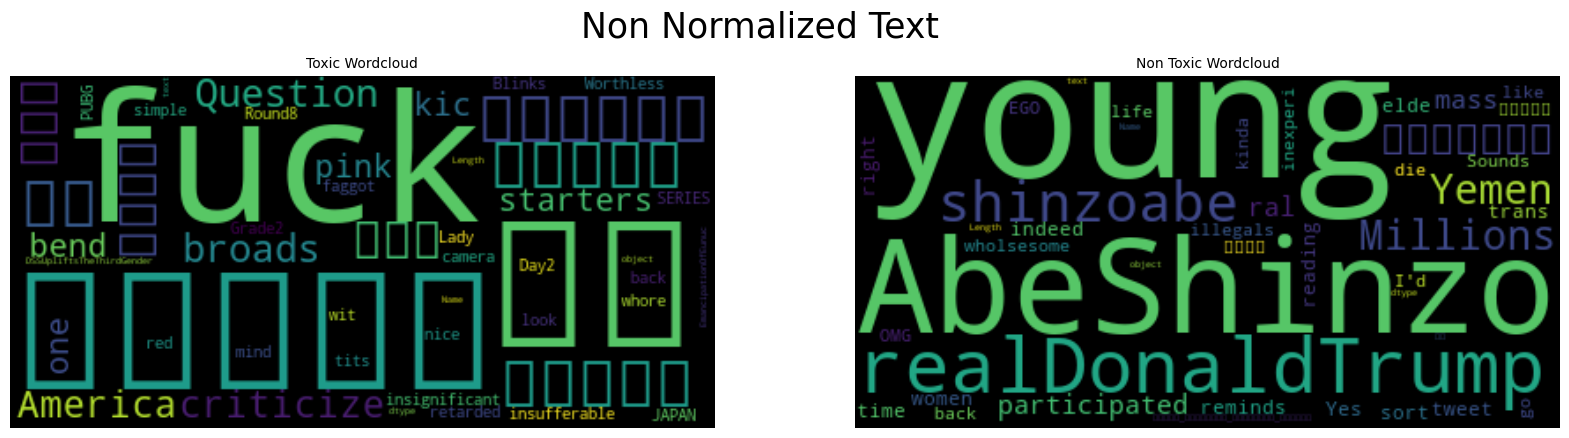

In [28]:
 
from wordcloud import WordCloud, STOPWORDS
word_cloud_non_toxic = new_df[new_df['toxic'] == "Non-Toxic"]['text']
word_cloud_toxic = new_df[new_df['toxic'] == "Toxic"]['text']

wordcloud_non = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(word_cloud_non_toxic))

wordcloud_toxic = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(word_cloud_toxic))

fig = plt.figure(figsize=[20,5])
plt.suptitle('Non Normalized Text', size = 25)

fig.add_subplot(1, 2, 1).set_title("Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_toxic, interpolation="bilinear")
plt.axis("off")

fig.add_subplot(1, 2, 2).set_title("Non Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_non, interpolation="bilinear")
plt.axis("off")

plt.show()

In [29]:
clean_toxic_text = [normalize_text(sent) for sent in new_df[new_df['toxic'] == "Toxic"]['text'][:]]
clean_non_toxic_text = [normalize_text(sent) for sent in new_df[new_df['toxic'] == "Non-Toxic"]['text'][:]]

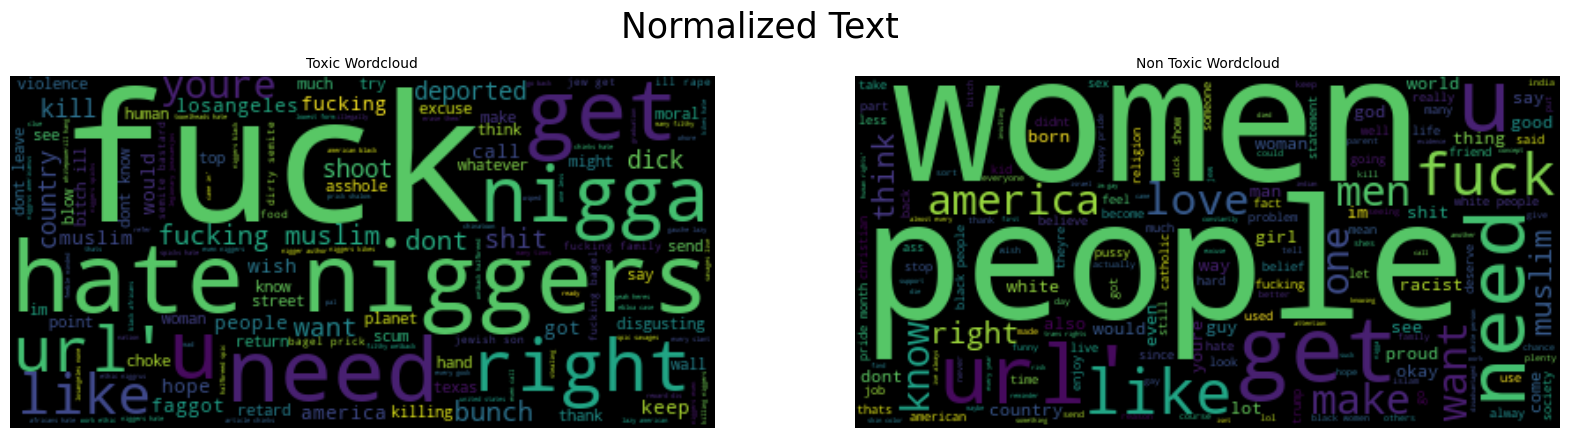

In [30]:
wordcloud_non = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(clean_non_toxic_text))

wordcloud_toxic = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(clean_toxic_text))

fig = plt.figure(figsize=[20,5])
plt.suptitle('Normalized Text', size = 25)

fig.add_subplot(1, 2, 1).set_title("Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_toxic, interpolation="bilinear")
plt.axis("off")

fig.add_subplot(1, 2, 2).set_title("Non Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_non, interpolation="bilinear")
plt.axis("off")

plt.show()

## Codeadd Markdown

### Preparing the Dataset and Dataloader
We will start with defining few key variables that will be used later during the training/fine tuning stage. Followed by creation of MultiLabelDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed the data in batches to the neural network for suitable training and processing. Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the docs at PyTorch

### MultiLabelDataset Dataset Class
This class is defined to accept the tokenizer, dataframe and max_length as input and generate tokenized output and tags that is used by the BERT model for training.

We are using the DistilBERT tokenizer to tokenize the data in the text column of the dataframe.

The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask, token_type_ids

To read further into the tokenizer, refer to this document

targets is the list of categories labled as 0 or 1 in the dataframe.

The MultiLabelDataset class is used to create 2 datasets, for training and for validation.

Training Dataset is used to fine tune the model: 80% of the original data

Validation Dataset is used to evaluate the performance of the model. The model has not seen this data during training.

### Dataloader
Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
This control is achieved using the parameters such as batch_size and max_len.
Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [31]:
new_df['text'] = [normalize_text(sent) for sent in new_df['text']][:]

In [10]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [12]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN)
test_data

FULL Dataset: (135556, 2)
TRAIN Dataset: (108445, 2)
TEST Dataset: (27111, 2)


,text,labels
0,It is about time for all illegals to go back t...,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]"
1,For starters bend over the one in pink and kic...,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0]"
2,White Small Little Invisible Clits Are A Disgr...,"[1, 1, 1, 1, 1, 1, 0, 0, 1, 0]"
3,Many of the families who are being separated a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,So hot!!! Wish she squirted in my mouth 💦,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0]"
...,...,...
27106,"I, a Catholic and a Jesuit, am grateful for th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
27107,"Please help support nonbinary pride, add a #Tw...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
27108,Lailat al Miraj mubarak to all Muslims.. I'm w...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
27109,"Umar khalid, sahela rashid, kanhiyan kumar जैस...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [13]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [14]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 10)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [15]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [16]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [17]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

In [18]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1it [00:01,  1.10s/it]

Epoch: 0, Loss:  0.7076143026351929


5002it [09:58,  8.37it/s]

Epoch: 0, Loss:  0.3306465148925781


10002it [19:55,  8.36it/s]

Epoch: 0, Loss:  0.3047165870666504


15002it [29:52,  8.36it/s]

Epoch: 0, Loss:  0.17816980183124542


20002it [39:50,  8.36it/s]

Epoch: 0, Loss:  0.2859933078289032


25002it [49:47,  8.35it/s]

Epoch: 0, Loss:  0.10778844356536865


27112it [53:59,  8.37it/s]
2it [00:00,  9.63it/s]

Epoch: 1, Loss:  0.07980450242757797


5002it [09:58,  8.35it/s]

Epoch: 1, Loss:  0.2959616482257843


10002it [19:55,  8.36it/s]

Epoch: 1, Loss:  0.11521808058023453


15002it [29:53,  8.37it/s]

Epoch: 1, Loss:  0.21430101990699768


20002it [39:51,  8.36it/s]

Epoch: 1, Loss:  0.4880681037902832


25002it [49:48,  8.36it/s]

Epoch: 1, Loss:  0.1619473546743393


27112it [54:00,  8.37it/s]
2it [00:00,  9.65it/s]

Epoch: 2, Loss:  0.514225423336029


5002it [09:57,  8.36it/s]

Epoch: 2, Loss:  0.26657259464263916


10002it [19:55,  8.37it/s]

Epoch: 2, Loss:  0.3842789828777313


15002it [29:52,  8.38it/s]

Epoch: 2, Loss:  0.3369339406490326


20002it [39:49,  8.37it/s]

Epoch: 2, Loss:  0.20033840835094452


25002it [49:47,  8.36it/s]

Epoch: 2, Loss:  0.20759086310863495


27112it [53:59,  8.37it/s]
2it [00:00,  9.51it/s]

Epoch: 3, Loss:  0.3324420750141144


5002it [09:57,  8.37it/s]

Epoch: 3, Loss:  0.4060368239879608


10002it [19:55,  8.36it/s]

Epoch: 3, Loss:  0.18833421170711517


15002it [29:52,  8.37it/s]

Epoch: 3, Loss:  0.30085933208465576


20002it [39:49,  8.36it/s]

Epoch: 3, Loss:  0.41473695635795593


25002it [49:47,  8.37it/s]

Epoch: 3, Loss:  0.309451162815094


27112it [53:59,  8.37it/s]
2it [00:00,  9.62it/s]

Epoch: 4, Loss:  0.20199885964393616


5002it [09:57,  8.35it/s]

Epoch: 4, Loss:  0.17896434664726257


10002it [19:54,  8.37it/s]

Epoch: 4, Loss:  0.29498520493507385


15002it [29:52,  8.36it/s]

Epoch: 4, Loss:  0.17924602329730988


20002it [39:49,  8.36it/s]

Epoch: 4, Loss:  0.20324698090553284


25002it [49:47,  8.35it/s]

Epoch: 4, Loss:  0.2398349791765213


27112it [53:59,  8.37it/s]
2it [00:00,  9.54it/s]

Epoch: 5, Loss:  0.16510508954524994


5002it [09:57,  8.36it/s]

Epoch: 5, Loss:  0.24716365337371826


10002it [19:55,  8.36it/s]

Epoch: 5, Loss:  0.44074010848999023


15002it [29:52,  8.37it/s]

Epoch: 5, Loss:  0.30606046319007874


20002it [39:50,  8.36it/s]

Epoch: 5, Loss:  0.24275875091552734


25002it [49:47,  8.37it/s]

Epoch: 5, Loss:  0.4070321023464203


27112it [53:59,  8.37it/s]
2it [00:00,  9.73it/s]

Epoch: 6, Loss:  0.2701350450515747


5002it [09:58,  8.35it/s]

Epoch: 6, Loss:  0.3132140338420868


10002it [19:55,  8.36it/s]

Epoch: 6, Loss:  0.3504800498485565


15002it [29:53,  8.37it/s]

Epoch: 6, Loss:  0.08901610225439072


20002it [39:50,  8.36it/s]

Epoch: 6, Loss:  0.2924242913722992


25002it [49:47,  8.36it/s]

Epoch: 6, Loss:  0.4062149226665497


27112it [53:59,  8.37it/s]
2it [00:00,  9.60it/s]

Epoch: 7, Loss:  0.1862499713897705


5002it [09:57,  8.32it/s]

Epoch: 7, Loss:  0.24812905490398407


10002it [19:55,  8.37it/s]

Epoch: 7, Loss:  0.32154902815818787


15002it [29:52,  8.35it/s]

Epoch: 7, Loss:  0.27263355255126953


20002it [39:50,  8.36it/s]

Epoch: 7, Loss:  0.24055390059947968


25002it [49:48,  8.33it/s]

Epoch: 7, Loss:  0.14283917844295502


27112it [54:00,  8.37it/s]
2it [00:00,  9.59it/s]

Epoch: 8, Loss:  0.11609064787626266


5002it [09:57,  8.35it/s]

Epoch: 8, Loss:  0.21034681797027588


10002it [19:55,  8.37it/s]

Epoch: 8, Loss:  0.16551735997200012


15002it [29:52,  8.35it/s]

Epoch: 8, Loss:  0.2613263428211212


20002it [39:50,  8.37it/s]

Epoch: 8, Loss:  0.24770335853099823


25002it [49:48,  8.37it/s]

Epoch: 8, Loss:  0.14618909358978271


27112it [54:00,  8.37it/s]
2it [00:00,  9.57it/s]

Epoch: 9, Loss:  0.1941431164741516


5002it [09:58,  8.34it/s]

Epoch: 9, Loss:  0.14433245360851288


10002it [19:55,  8.34it/s]

Epoch: 9, Loss:  0.4928853511810303


15002it [29:53,  8.35it/s]

Epoch: 9, Loss:  0.23638391494750977


20002it [39:51,  8.36it/s]

Epoch: 9, Loss:  0.30293554067611694


25002it [49:49,  8.35it/s]

Epoch: 9, Loss:  0.22814665734767914


27112it [54:01,  8.36it/s]


In [19]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [20]:
outputs, targets = validation(testing_loader)

final_outputs = np.array(outputs) >=0.5

6778it [04:38, 24.31it/s]


In [21]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

Hamming Score = 0.6947781255543787
Hamming Loss = 0.1525321825089447


In [22]:
class MultiLabelTestDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, "scrapped_comments.csv"))

/kaggle/input/scrapped-comments/scrapped_comments.csv


In [24]:
df1=pd.read_csv("/kaggle/input/scrapped-comments/scrapped_comments.csv")
df1.rename(columns = {'comment':'text'}, inplace = True)
prediction_set = MultiLabelTestDataset(df1, tokenizer, MAX_LEN)
prediction_loader = DataLoader(prediction_set, **test_params)

In [25]:
def prediction(prediction_loader):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(prediction_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [26]:
outputs = prediction(prediction_loader)
df3= pd.DataFrame(outputs[1:])
df2=pd.DataFrame()
df2=outputs
f = lambda x: 1 if x>0.5 else 0
df2=df3.applymap(f)
df2.columns = ['sentiment'	,'respect',	'insult', 'humiliate',	'status',	'dehumanize',	'violence',	'genocide',	'attack_defend',	'hatespeech']
result = pd.concat([df1, df2], axis=1, join='inner')
result.drop(result.columns[result.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
result=result.dropna(axis=0)
# Reset index after drop
result=result.dropna().reset_index(drop=True)
display(result)


518it [00:20, 25.14it/s]


,text,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
0,Then when you take into account the countrywid...,1,0,0,0,0,0,0,0,0,0
1,Thank you so so much for 400k subscribers. Sup...,1,1,1,0,0,0,0,0,0,0
2,With inflation at its highest level in four de...,0,0,0,0,0,0,0,0,0,0
3,Then when you take into account the countrywid...,1,1,1,0,1,0,0,0,1,0
4,HSR - Shinkansen works very well in Japan beca...,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2048,If you acted like duck you will see perking duck,0,0,0,0,0,0,0,0,0,0
2049,Didn’t you at 28 days like 2 weeks ago,1,1,1,0,0,0,0,0,1,0
2050,This is why they want Taiwan cause of how much...,0,0,0,0,0,0,0,0,0,0
2051,"Congratulations on the 400k, you deserve more....",0,1,1,0,0,0,0,0,0,0


In [27]:
result['Sum_Result'] = result.loc[0:,['dehumanize','violence','genocide','attack_defend','hatespeech']].sum(axis=1)
result

,text,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,Sum_Result
0,Then when you take into account the countrywid...,1,0,0,0,0,0,0,0,0,0,0
1,Thank you so so much for 400k subscribers. Sup...,1,1,1,0,0,0,0,0,0,0,0
2,With inflation at its highest level in four de...,0,0,0,0,0,0,0,0,0,0,0
3,Then when you take into account the countrywid...,1,1,1,0,1,0,0,0,1,0,1
4,HSR - Shinkansen works very well in Japan beca...,1,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2048,If you acted like duck you will see perking duck,0,0,0,0,0,0,0,0,0,0,0
2049,Didn’t you at 28 days like 2 weeks ago,1,1,1,0,0,0,0,0,1,0,1
2050,This is why they want Taiwan cause of how much...,0,0,0,0,0,0,0,0,0,0,0
2051,"Congratulations on the 400k, you deserve more....",0,1,1,0,0,0,0,0,0,0,0


In [28]:
# Saving the files for inference

output_model_file = r'./pytorch_distilbert_news.bin'
output_vocab_file = r'./vocab_distilbert_news.bin'

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

model_to_save = model.module if hasattr(model, 'module') else model
torch.save(model_to_save.state_dict(), output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

Saved


('./vocab_distilbert_news.bin',)